# rawaudiovae

A dataset and pretrained models can be found here: 

https://drive.google.com/file/d/1e_X2Ir26iypSdSa6pRCJBy2q5t9zXFBb

Please download this folder and unzip it under the ./content folder

In [ ]:

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader

from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import torchaudio
Resample = torchaudio.transforms.Resample(44100, 48000, resampling_method='kaiser_window')
device = 'cuda:0'
Resample = Resample.to(device)

from pathlib import Path
import random
import numpy as np
from scipy import interpolate as sp_interpolate
import json

import librosa
import librosa.display

import soundfile as sf
# import sounddevice as sd
import configparser
import random
import json
import matplotlib.pyplot as plt
import IPython.display as display

In [ ]:
sampling_rate = 44100
sr = sampling_rate

hop_length = 128

segment_length = 1024
n_units = 2048
latent_dim = 256
device = 'cuda:0'

batch_size = 256

audio_fold = Path(r'/content/2022-zkm-workshop/ltsp/erokia/audio')
audio = audio_fold
lts_audio_files = [f for f in audio_fold.glob('*.wav')]

In [ ]:
# Following should give you more than 0

len(lts_audio_files)

1139

In [ ]:
# Models 

class raw_VAE(nn.Module):
  def __init__(self, segment_length, n_units, latent_dim):
    super(raw_VAE, self).__init__()

    self.segment_length = segment_length
    self.n_units = n_units
    self.latent_dim = latent_dim
    
    self.fc1 = nn.Linear(segment_length, n_units)
    self.fc21 = nn.Linear(n_units, latent_dim)
    self.fc22 = nn.Linear(n_units, latent_dim)
    self.fc3 = nn.Linear(latent_dim, n_units)
    self.fc4 = nn.Linear(n_units, segment_length)

  def encode(self, x):
      h1 = F.relu(self.fc1(x))
      return self.fc21(h1), self.fc22(h1)

  def reparameterize(self, mu, logvar):
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      return mu + eps*std

  def decode(self, z):
      h3 = F.relu(self.fc3(z))
      return F.tanh(self.fc4(h3))

  def forward(self, x):
      mu, logvar = self.encode(x.view(-1, self.segment_length))
      z = self.reparameterize(mu, logvar)
      return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, kl_beta, segment_length):
  recon_loss = F.mse_loss(recon_x, x.view(-1, segment_length))

  # see Appendix B from VAE paper:
  # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
  # https://arxiv.org/abs/1312.6114
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

  return recon_loss + ( kl_beta * KLD)

In [ ]:
# Datasets 

class AudioDataset(torch.utils.data.Dataset):
    """
    This is the main class that calculates the spectrogram and returns the
    spectrogram, audio pair.
    """

    def __init__(self, audio_np, segment_length, sampling_rate, hop_size, transform=None):
        
        self.transform = transform
        self.sampling_rate = sampling_rate
        self.segment_length = segment_length
        self.hop_size = hop_size
        
        if segment_length % hop_size != 0:
            raise ValueError("segment_length {} is not a multiple of hop_size {}".format(segment_length, hop_size))

        if len(audio_np) % hop_size != 0:
            num_zeros = hop_size - (len(audio_np) % hop_size)
            audio_np = np.pad(audio_np, (0, num_zeros), 'constant', constant_values=(0,0))

        self.audio_np = audio_np
        
    def __getitem__(self, index):
        
        # Take segment
        seg_start = index * self.hop_size
        seg_end = (index * self.hop_size) + self.segment_length
        sample = self.audio_np[ seg_start : seg_end ]
        
        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return (len(self.audio_np) // self.hop_size) - (self.segment_length // self.hop_size) + 1

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return torch.from_numpy(sample)

class TestDataset(torch.utils.data.Dataset):
    """
    This is the main class that calculates the spectrogram and returns the
    spectrogram, audio pair.
    """

    def __init__(self, audio_np, segment_length, sampling_rate, transform=None):
        
        self.transform = transform
        self.sampling_rate = sampling_rate
        self.segment_length = segment_length
        
        if len(audio_np) % segment_length != 0:
            num_zeros = segment_length - (len(audio_np) % segment_length)
            audio_np = np.pad(audio_np, (0, num_zeros), 'constant', constant_values=(0,0))

        self.audio_np = audio_np
        
    def __getitem__(self, index):
        
        # Take segment
        seg_start = index * self.segment_length
        seg_end = (index * self.segment_length) + self.segment_length
        sample = self.audio_np[ seg_start : seg_end ]
        
        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return len(self.audio_np) // self.segment_length

In [ ]:
state = torch.load(Path(r'/content/2022-zkm-workshop/nospectral/erokia/spectralvae/run-000/checkpoints/ckpt_00500'))
raw_model = raw_VAE(segment_length, n_units, latent_dim).to(device)
raw_model.load_state_dict(state['state_dict'])
raw_model.eval()

raw_VAE(
  (fc1): Linear(in_features=1024, out_features=2048, bias=True)
  (fc21): Linear(in_features=2048, out_features=256, bias=True)
  (fc22): Linear(in_features=2048, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2048, bias=True)
  (fc4): Linear(in_features=2048, out_features=1024, bias=True)
)

## Stepwise Interpolations

In [ ]:
# Load audio files ...

test_audio_1_path = lts_audio_files[random.randint(0, len(lts_audio_files) - 1)]
test_audio_1, fs = librosa.load(test_audio_1_path, sr=None)

In [ ]:
display.Audio(test_audio_1, rate=fs)

In [ ]:
test_audio_2_path = lts_audio_files[random.randint(0, len(lts_audio_files)- 1)]
test_audio_2, fs = librosa.load(test_audio_2_path, sr=None)

In [ ]:
display.Audio(test_audio_2, rate=fs)

In [ ]:
# We should match the audio lengths
# 0 is crop the longer, 
# 1 is repeat the shorter, 
#  

# TODO make this an array/tensor of two - check if padding functions have these 

match_size = 1

if match_size == 0:
    if test_audio_1.shape[0] < test_audio_2.shape[0]:
        test_audio_2 = test_audio_2[:test_audio_1.shape[0]]
    else:
        test_audio_1 = test_audio_1[:test_audio_2.shape[0]]

if match_size == 1:
    if test_audio_1.shape[0] < test_audio_2.shape[0]:
        while test_audio_1.shape[0] < test_audio_2.shape[0]:
            test_audio_1 = np.concatenate((test_audio_1, test_audio_1), 0)
        test_audio_1 = test_audio_1[:test_audio_2.shape[0]] 

    else:
        while test_audio_2.shape[0] < test_audio_1.shape[0]:
            test_audio_2 = np.concatenate((test_audio_2, test_audio_2), 0)
        test_audio_2 = test_audio_2[:test_audio_1.shape[0]]

# Create the dataset
test_dataset1 = TestDataset(test_audio_1, segment_length = segment_length, sampling_rate = sampling_rate, transform=ToTensor())
test_dataset2 = TestDataset(test_audio_2, segment_length = segment_length, sampling_rate = sampling_rate, transform=ToTensor())

test_dataloader1 = DataLoader(test_dataset1, batch_size = batch_size, shuffle=False)
test_dataloader2 = DataLoader(test_dataset2, batch_size = batch_size, shuffle=False)


In [ ]:
def raw_to_z_dist(test_dataloader, raw_model, device):
    init_test = True
    for iterno, test_sample in enumerate(test_dataloader):
        with torch.no_grad():
            test_sample = test_sample.to(device)
            test_mu, test_logvar = raw_model.encode(test_sample)

        if init_test:
            test_z_mu = test_mu 
            test_z_logvar = test_logvar
            init_test = False

        else:
            test_z_mu = torch.cat((test_z_mu, test_mu ),0)
            test_z_logvar = torch.cat((test_z_logvar, test_logvar ),0)
    return test_z_mu, test_z_logvar

In [ ]:
# Z dist

test1_z_mu, test1_z_logvar = raw_to_z_dist(test_dataloader1, raw_model, device)
test2_z_mu, test2_z_logvar = raw_to_z_dist(test_dataloader2, raw_model, device)

In [ ]:
def raw_interpolate_stepwise_z_dist(test1_z_mu, test1_z_logvar, test2_z_mu, test2_z_logvar, interpolation_range, raw_model):

    init_test = True
    for interpolation in interpolation_range:

        inter_z_mu = torch.add( torch.mul(test1_z_mu, (1-interpolation)), torch.mul(test2_z_mu, interpolation) )
        inter_z_logvar = torch.add( torch.mul(test1_z_logvar, (1-interpolation)), torch.mul(test2_z_logvar, interpolation) )
        
        with torch.no_grad():
            test_pred_z = raw_model.reparameterize(inter_z_mu, inter_z_logvar)
            test_pred = raw_model.decode(test_pred_z)

        if init_test:
            test_predictions = test_pred
            init_test = False

        else:
            test_predictions = torch.cat((test_predictions, test_pred ),0)
        
    return test_predictions

In [ ]:
interpolation_range = np.arange(0, 1.1, 0.2)

inter_raw_all = raw_interpolate_stepwise_z_dist(test1_z_mu, test1_z_logvar, test2_z_mu, test2_z_logvar, interpolation_range, raw_model)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
inter_raw_all_np = inter_raw_all.view(-1).cpu().numpy()

In [ ]:
display.Audio(inter_raw_all_np, rate=fs)

This cell output is too large and can only be displayed while logged in.


In [ ]:
out_path  = '/content/my_audio.wav'
sf.write(out_path, inter_raw_all_np, sr)

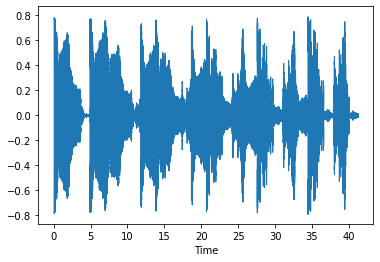

In [ ]:
librosa.display.waveshow(inter_raw_all_np, sr=sr)

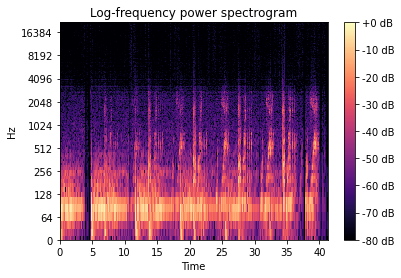

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(inter_raw_all_np, hop_length=hop_length)),ref=np.max)
img = librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length, x_axis='time', ax=ax)
ax.set(title='Log-frequency power spectrogram')
ax.label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")


## Interpolations in Meso-scale

In [ ]:
def concat_random_audio(audio_files, duration, sampling_rate):
    
    # concat random files from the dataset until the array is [duration] secs long.

    array_length = 0

    init = True

    while array_length < (duration * sampling_rate):
        
        path = audio_files[random.randint(0, len(audio_files)- 1)]
        
        y, fs = librosa.load(path, sr=None)
        
        if init:
            audio_1 = y
        else:
            audio_1 = np.concatenate((audio_1, y), 0)

        init = False
        array_length = audio_1.shape[0]

    init = True
    array_length = 0

    while array_length < (duration * sampling_rate):
        
        path = audio_files[random.randint(0, len(audio_files)- 1)]
        
        y, fs = librosa.load(path, sr=None)
        
        if init:
            audio_2 = y
        else:
            audio_2 = np.concatenate((audio_2, y), 0)

        init = False
        array_length = audio_2.shape[0]

    return audio_1[:duration * sampling_rate], audio_2[:duration * sampling_rate]

In [ ]:
audio_1, audio_2 = concat_random_audio(lts_audio_files, duration=120, sampling_rate=sampling_rate)

In [ ]:
librosa.display.waveshow(audio_1, sr=sr)
display.Audio(audio_1, rate=sr)

In [ ]:
librosa.display.waveshow(audio_2, sr=sr)
display.Audio(audio_2, rate=sr)

In [ ]:
som_clusters_path = r"./content/2022-zkm-workshop/ltsp/erokia/som/clusters.json"
som_data_path = r"./content/2022-zkm-workshop/ltsp/erokia/som/data-concatenated.json"

with open(som_clusters_path, 'r') as f:
  som_clusters_dict = json.load(f)

with open(som_data_path, 'r') as f:
  som_data_dict = json.load(f)

In [ ]:
def concat_audio_som(audio_files, sampling_rate, cluster_idx, som_clusters_dict, som_data_dict):
    init = True
    cluster = som_clusters_dict[str(cluster_idx)]

    for index in cluster:
    
        path = som_data_dict[str(index)][1]
        path = audio_files.joinpath(path)
        y, fs = librosa.load(path, sr=None)
        
        if init:
            audio = y
        else:
            audio = np.concatenate((audio, y), 0)

        init = False

    return audio

In [ ]:
cluster_idx = 18
test_audio_1 = concat_audio_som(audio, sampling_rate, cluster_idx, som_clusters_dict, som_data_dict)
len(test_audio_1) / sampling_rate

347.3124716553288

In [ ]:
librosa.display.waveshow(test_audio_1, sr=sr)
display.Audio(test_audio_1, rate=sr)

In [ ]:
cluster_idx = 24
test_audio_2 = concat_audio_som(audio, sampling_rate, cluster_idx, som_clusters_dict, som_data_dict)
len(test_audio_2) / sampling_rate

30.223673469387755

In [ ]:
librosa.display.waveshow(test_audio_2, sr=sr)
display.Audio(test_audio_2, rate=sr)

In [ ]:
def match_audio_size(audio_1, audio_2, match_size = 1):
    # We should match the audio lengths
    # 0 is crop the longer, 
    # 1 is repeat the shorter, 
    #  

    match_size = 1

    if match_size == 0:
        if audio_1.shape[0] < audio_2.shape[0]:
            audio_2 = audio_2[:audio_1.shape[0]]
        else:
            audio_1 = audio_1[:audio_2.shape[0]]

    if match_size == 1:
        if audio_1.shape[0] < audio_2.shape[0]:
            while audio_1.shape[0] < audio_2.shape[0]:
                audio_1 = np.concatenate((audio_1, audio_1), 0)
            audio_1 = audio_1[:audio_2.shape[0]] 

        else:
            while audio_2.shape[0] < audio_1.shape[0]:
                audio_2 = np.concatenate((audio_2, audio_2), 0)
            audio_2 = audio_2[:audio_1.shape[0]]
    return audio_1, audio_2

In [ ]:
test_audio_1, test_audio_2 = match_audio_size(test_audio_1, test_audio_2, match_size = 1)

long_dataset1 = TestDataset(test_audio_1, segment_length = segment_length, sampling_rate = sampling_rate, transform=ToTensor())
long_dataloader1 = DataLoader(long_dataset1, batch_size = batch_size, shuffle=False)
long1_z_mu, long1_z_logvar = raw_to_z_dist(long_dataloader1, raw_model, device)

long_dataset2 = TestDataset(test_audio_2, segment_length = segment_length, sampling_rate = sampling_rate, transform=ToTensor())
long_dataloader2 = DataLoader(long_dataset2, batch_size = batch_size, shuffle=False)
long2_z_mu, long2_z_logvar = raw_to_z_dist(long_dataloader2, raw_model, device)


In [ ]:
# interpolation = np.sin(np.linspace(-10* np.pi, 10 * np.pi, 20000))
interpolation = np.sin(np.linspace(-500* np.pi, 500* np.pi, 20000))



In [ ]:
  
# match the size of interpolation array to audio array using scipy interpolation 
f_stretch = sp_interpolate.interp1d(np.arange(0, len(interpolation)), interpolation)
my_stretched_alfa = f_stretch(np.linspace(0.0, len(interpolation)-1, len(long1_z_mu)))
my_stretched_alfa = torch.from_numpy(my_stretched_alfa).to(device)

# repeat the alfa values to 256 latent dimensions, that is, each alfa value is a constant multiplier for a latent vector
my_stretched_alfa = torch.repeat_interleave(my_stretched_alfa.unsqueeze(1), long1_z_mu.shape[1], axis=1)

#generate mixed latent vectors    
#alfa(latent1-latent2)+latent2 = alfa * latent1 + (1-alfa) * latent2
inter_z_mu = torch.add( torch.mul(long1_z_mu, (1-my_stretched_alfa)), torch.mul(long2_z_mu, my_stretched_alfa) )
inter_z_logvar = torch.add( torch.mul(long1_z_logvar, (1-my_stretched_alfa)), torch.mul(long2_z_logvar, my_stretched_alfa) )

init_test = True
with torch.no_grad():
     
    test_pred_z = raw_model.reparameterize(inter_z_mu, inter_z_logvar)
    test_pred = raw_model.decode(test_pred_z.float())

    if init_test:
        test_predictions = test_pred
        init_test = False

    else:
        test_predictions = torch.cat((test_predictions, test_pred ),0)

out_audio = test_predictions.view(-1).cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
import soundfile as sf

out_path  = '/content/normal.wav'
sf.write(out_path, out_audio, sr)

In [ ]:
librosa.display.waveshow(out_audio, sr=sr)
display.Audio(out_audio, rate=sr)

## Interpolations with Extensions

In [ ]:
def concat_random_audio(audio_files, duration, sampling_rate):
    
    # concat random files from the dataset until the array is [duration] secs long.

    array_length = 0

    init = True

    while array_length < (duration * sampling_rate):
        
        path = audio_files[random.randint(0, len(audio_files)- 1)]
        
        y, fs = librosa.load(path, sr=None)
        
        if init:
            audio_1 = y
        else:
            audio_1 = np.concatenate((audio_1, y), 0)

        init = False
        array_length = audio_1.shape[0]

    init = True
    array_length = 0

    while array_length < (duration * sampling_rate):
        
        path = audio_files[random.randint(0, len(audio_files)- 1)]
        
        y, fs = librosa.load(path, sr=None)
        
        if init:
            audio_2 = y
        else:
            audio_2 = np.concatenate((audio_2, y), 0)

        init = False
        array_length = audio_2.shape[0]

    return audio_1[:duration * sampling_rate], audio_2[:duration * sampling_rate]

In [ ]:
audio_1, audio_2 = concat_random_audio(lts_audio_files, duration=120, sampling_rate=sampling_rate)


In [ ]:
librosa.display.waveshow(audio_1, sr=sr)
display.Audio(audio_1, rate=sr)

In [ ]:
librosa.display.waveshow(audio_2, sr=sr)
display.Audio(audio_2, rate=sr)

In [ ]:
def concat_audio_som(audio_files, sampling_rate, cluster_idx, som_clusters_dict, som_data_dict):
    init = True
    cluster = som_clusters_dict[str(cluster_idx)]

    for index in cluster:
    
        path = som_data_dict[str(index)][1]
        path = audio_files.joinpath(path)
        y, fs = librosa.load(path, sr=None)
        
        if init:
            audio = y
        else:
            audio = np.concatenate((audio, y), 0)

        init = False

    return audio

In [ ]:
som_clusters_path = r"/content/2022-zkm-workshop/ltsp/erokia/som/clusters.json"
som_data_path = r"/content/2022-zkm-workshop/ltsp/erokia/som/data-concatenated.json"

with open(som_clusters_path, 'r') as f:
  som_clusters_dict = json.load(f)

with open(som_data_path, 'r') as f:
  som_data_dict = json.load(f)

In [ ]:
cluster_idx = 32
test_audio_1 = concat_audio_som(audio, sampling_rate, cluster_idx, som_clusters_dict, som_data_dict)
len(test_audio_1) / sampling_rate

130.4671201814059

In [ ]:
cluster_idx = 46
test_audio_2 = concat_audio_som(audio, sampling_rate, cluster_idx, som_clusters_dict, som_data_dict)
len(test_audio_2) / sampling_rate

32.12190476190476

In [ ]:
librosa.display.waveshow(test_audio_1, sr=sr)
display.Audio(test_audio_1, rate=sr)

In [ ]:
librosa.display.waveshow(test_audio_2, sr=sr)
display.Audio(test_audio_2, rate=sr)

In [ ]:
def match_audio_size(audio_1, audio_2, match_size = 1):
    # We should match the audio lengths
    # 0 is crop the longer, 
    # 1 is repeat the shorter, 
    #  

    match_size = 1

    if match_size == 0:
        if audio_1.shape[0] < audio_2.shape[0]:
            audio_2 = audio_2[:audio_1.shape[0]]
        else:
            audio_1 = audio_1[:audio_2.shape[0]]

    if match_size == 1:
        if audio_1.shape[0] < audio_2.shape[0]:
            while audio_1.shape[0] < audio_2.shape[0]:
                audio_1 = np.concatenate((audio_1, audio_1), 0)
            audio_1 = audio_1[:audio_2.shape[0]] 

        else:
            while audio_2.shape[0] < audio_1.shape[0]:
                audio_2 = np.concatenate((audio_2, audio_2), 0)
            audio_2 = audio_2[:audio_1.shape[0]]
    return audio_1, audio_2


In [ ]:
test_audio_1, test_audio_2 = match_audio_size(test_audio_1, test_audio_2, match_size = 1)

long_dataset1 = AudioDataset(test_audio_1, segment_length = segment_length, sampling_rate = sampling_rate, hop_size = hop_length, transform=ToTensor())
long_dataloader1 = DataLoader(long_dataset1, batch_size = batch_size, shuffle=False)
long1_z_mu, long1_z_logvar = raw_to_z_dist(long_dataloader1, raw_model, device)

long_dataset2 = AudioDataset(test_audio_2, segment_length = segment_length, sampling_rate = sampling_rate, hop_size = hop_length, transform=ToTensor())
long_dataloader2 = DataLoader(long_dataset2, batch_size = batch_size, shuffle=False)
long2_z_mu, long2_z_logvar = raw_to_z_dist(long_dataloader2, raw_model, device)

In [ ]:
interpolation = np.sin(np.linspace(-np.pi, np.pi, 2000))
# interpolation = np.clip(interpolation * 10, -1, 1)

In [ ]:
  
# match the size of interpolation array to audio array using scipy interpolation 
f_stretch = sp_interpolate.interp1d(np.arange(0, len(interpolation)), interpolation)
my_stretched_alfa = f_stretch(np.linspace(0.0, len(interpolation)-1, len(long1_z_mu)))
my_stretched_alfa = torch.from_numpy(my_stretched_alfa).to(device)

# repeat the alfa values to 256 latent dimensions, that is, each alfa value is a constant multiplier for a latent vector
my_stretched_alfa = torch.repeat_interleave(my_stretched_alfa.unsqueeze(1), long1_z_mu.shape[1], axis=1)

#generate mixed latent vectors    
#alfa(latent1-latent2)+latent2 = alfa * latent1 + (1-alfa) * latent2
inter_z_mu = torch.add( torch.mul(long1_z_mu, (1-my_stretched_alfa)), torch.mul(long2_z_mu, my_stretched_alfa) )
inter_z_logvar = torch.add( torch.mul(long1_z_logvar, (1-my_stretched_alfa)), torch.mul(long2_z_logvar, my_stretched_alfa) )

init_test = True
with torch.no_grad():
     
    test_pred_z = raw_model.reparameterize(inter_z_mu, inter_z_logvar)
    test_pred = raw_model.decode(test_pred_z.float())

    if init_test:
        test_predictions = test_pred
        init_test = False

    else:
        test_predictions = torch.cat((test_predictions, test_pred ),0)


out_audio = test_predictions.view(-1).cpu().numpy()


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
import soundfile as sf

out_path  = '/content/hacky.wav'
sf.write(out_path, out_audio, sr)

## Acknowledgements

This code is built within the following research residency:

https://kivanctatar.com/Coding-Latent-No-1

This work was partially supported by the Wallenberg AI, Autonomous Systems and Software Program – Humanities and Society (WASP-HS) funded by the Marianne and Marcus Wallenberg Foundation and the Marcus and Amalia Wallenberg Foundation.